In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [108]:
import xgboost as xgb

In [2]:
import ta
import talib
from tech_indicators import stoch,stoch_signal

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

## Preparing Data 


In [4]:
fcpo_data_daily=pd.read_hdf('processed_dta.h5','fcpo_data_daily')
fcpo_data_hourly=pd.read_hdf('processed_dta.h5','fcpo_data_hourly')


In [81]:
## TODO 
# normalise the high,low,open and close prices
# generate features based on signal crossovers and trend reversals
# generate pattern based features using TA-Lib (candlesticks etc)
# generate investment evaluation functions

## Technical Indicators

* Momentum Indicators - Leading Indicators; Relative Change
 * MACD Diff - Crossover strategy
 * Relative Strength Index: An oscillator between 0 and 100; > 70-overbought, < 30-oversold
* Trend Indicators - Lagging Indicators
 * ADX - indicates the strength of trend ( < 20 no trend , > 20 trend)
* Volume Indicators
 * Force index
 * On Balance Volume (OBV)
* Volatility Indicators
 * Bollinger Bands: Based on the moving average and n*standard deviations
 * Average True Range (ATR): Based on the current period's high, low and previous closing prices

Support and Resistance represents the lowest and highest values of the price in the given time period. It forms a basis for when to enter and exit positions and to be used together with other TA for devising features.

Infer the signals from the context

* Signal line crossovers ( switching between +/- values of macd diff)
* Center line crossovers ( switching between +/- values of macd)
* Divergence: Track the higher-highs/lower-lows of the indicators and price indexes to generate reversal flags

Momentum indicators work during sidwards moving market conditions, when the market is trending upwards/downwards a different strategy needs to be formulated.
* Trend look-back period should be atleast 2-3 times higher than the momentum look-back periods, to detect longer trend and then use the momentum for decisions
* Look for occassional oversold conditions in upward trend, or overbrought in downward trend


### Feature Engineering

* Trend indicators based on close > sma(close,30)
* Check for Trend to continue atleast 3 continuous periods

In [5]:
def generate_tech_ind(fcpo_df):
    fcpo_df_tind=pd.DataFrame({
        'ema_slow':ta.trend.ema_slow(fcpo_df['Close'],n_slow=30).bfill(),
        'ema_fast':ta.trend.ema_fast(fcpo_df['Close'],n_fast=12).bfill(),
        'macd': ta.trend.macd(fcpo_df['Close']).bfill(),
        'macd_signal': ta.trend.macd_signal(fcpo_df['Close']).bfill(),
        'stoch' : stoch(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'stoch_signal' : stoch_signal(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'rsi':ta.momentum.rsi(fcpo_df['Close']).bfill(),
        'adx': ta.trend.adx(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'atr': ta.volatility.average_true_range(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'find' : ta.volume.force_index(fcpo_df['Close'],fcpo_df['Volume']).bfill(),
        'eom': ta.volume.ease_of_movement(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close'],fcpo_df['Volume'],n=10,fillna=True).bfill()
       })
    return fcpo_df_tind

In [6]:
fcpo_daily_tind=generate_tech_ind(fcpo_data_daily)
fcpo_hourly_tind=generate_tech_ind(fcpo_data_hourly)

### Momentum Indicators - MACD and RSI

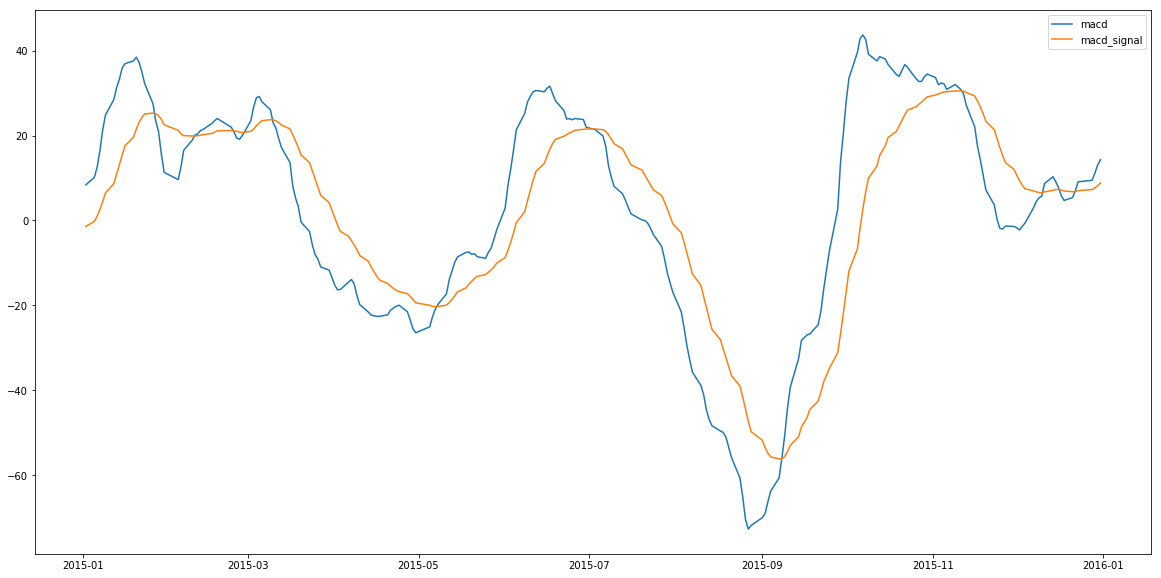

In [33]:
plt.figure(figsize=(20,10))
plt.plot(fcpo_daily_tind['2015-01-01':'2016-01-01']['macd'])
plt.plot(fcpo_daily_tind['2015-01-01':'2016-01-01']['macd_signal'])
plt.legend()
plt.show()

## Representing data in Candle sticks format

In [34]:
selected_fcpo_data=fcpo_data_daily['2015-01-01':'2016-01-01']

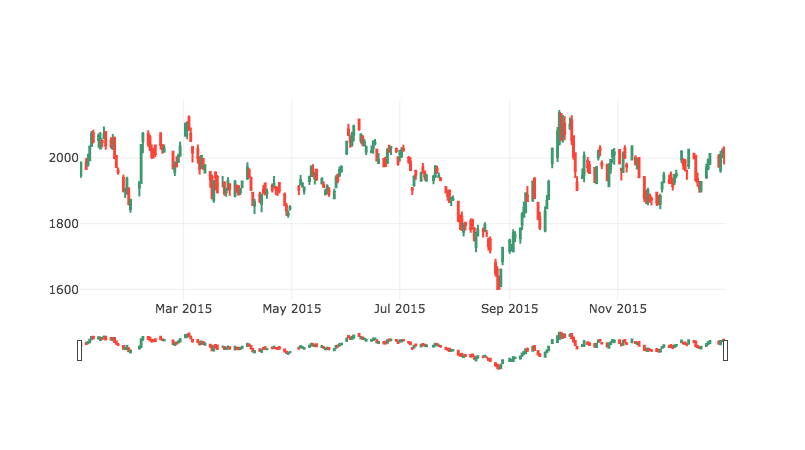

In [35]:
cndl_trace=go.Candlestick(x=selected_fcpo_data.index,
            open=selected_fcpo_data.Open,
            close=selected_fcpo_data.Close,
            high=selected_fcpo_data.High,
            low=selected_fcpo_data.Low)
iplot([cndl_trace])

## Using Prophet for forecasting

In [19]:
#from fbprophet import Prophet
#prophet_model=Prophet()
#prophet_data_df=fcpo_data_daily['Close'].reset_index()
#prophet_data_df=prophet_data_df.rename(columns={'Date':'ds','Close':'y'})
#prophet_model.fit(prophet_data_df)

#prophet_forecast=prophet_model.make_future_dataframe(periods=365)
#prophet_forecast=prophet_model.predict(prophet_forecast)
#prophet_model.plot(prophet_forecast)

## Machine Learning model

In [7]:
fcpo_train=fcpo_daily_tind[:'2017-01-01']
fcpo_test = fcpo_daily_tind['2017-01-01':]

fcpo_lprofit_train=fcpo_train.merge(fcpo_data_daily[['Open','next_open_change_pct','sprofit_ind']],left_index=True,right_index=True)
fcpo_lprofit_test=fcpo_test.merge(fcpo_data_daily[['Open','next_open_change_pct','sprofit_ind']],left_index=True,right_index=True)

In [8]:
fcpo_lprofit_traindata=fcpo_lprofit_train.iloc[:,1:-1]
fcpo_lprofit_trainlabels=fcpo_lprofit_train.iloc[:,-1:]

fcpo_lprofit_testdata=fcpo_lprofit_test.iloc[:,1:-1]
fcpo_lprofit_testlabels=fcpo_lprofit_test.iloc[:,-1]

In [ ]:
fcpo_lprofit_xgtrain=xgb.DMatrix(fcpo_lprofit_traindata,fcpo_lprofit_trainlabels)
param = {'max_depth': 2, 'eta': 0.2, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
#fcpo_lprofit_model = xgb.train(param, fcpo_lprofit_xgtrain, 10)

In [71]:
rf_lprofit= RandomForestClassifier(n_estimators=200,max_depth=12,min_samples_split=2,
                                  min_samples_leaf=2)
rf_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
rf_test_proba=rf_lprofit.predict_proba(fcpo_lprofit_testdata)
rf_test_predlabels=rf_lprofit.predict(fcpo_lprofit_testdata)

In [73]:
roc_auc_score(fcpo_lprofit_testlabels,rf_test_predlabels)

0.6578454332552693

In [74]:
confusion_matrix(fcpo_lprofit_testlabels,rf_test_predlabels)

array([[288,  17],
       [ 44,  26]])

In [57]:
gbm_lprofit=GradientBoostingClassifier(n_estimators=150,max_depth=15,min_samples_leaf=3,
                                       min_samples_split=3,learning_rate=0.1)
gbm_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [58]:
gbm_test_proba=gbm_lprofit.predict_proba(fcpo_lprofit_testdata)
gbm_test_predlabels=gbm_lprofit.predict(fcpo_lprofit_testdata)

In [59]:
roc_auc_score(fcpo_lprofit_testlabels,gbm_test_predlabels)

0.7387587822014052

In [60]:
confusion_matrix(fcpo_lprofit_testlabels,gbm_test_predlabels)

array([[272,  33],
       [ 29,  41]])

## Model Evaluation Metrics

The final objective of this study is to improve the ROI, hence we are focused on creating a score-card to measure the investement metrics to select the final model,

- Total Returns
- Maximum Drawdown
- Number of Wins
- Number of Losses

**Calculation of Returns**

* When the sprofit_indicator is true, then return is (open_price - next_low_price) - (commission_price),
* Else when the sprofit_indicator is false, the model waits until the end of the day before selling it hence the return is (open_price - next_close_price) - (commission_price)


In [120]:
def calculate_returns(x,commission_price):
    return_myr=0
    if x['gbm_prediction']==0:
        return_myr=0
    elif x['gbm_prediction']==1:
        if x['sprofit_ind']==1:
            return_myr=(x['Open']-x['next_1low'])-commission_price
        elif x['sprofit_ind']==0:
            return_myr=(x['Open']-x['next_1close'])-commission_price
    return return_myr

def max_drawdown(X):
    mdd = 0
    peak = X[0]
    mdd_peak=0
    mdd_x=0
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
            mdd_peak=peak
            mdd_x=x
    return mdd_peak,mdd_x,mdd 

In [98]:
fcpo_eval_df=fcpo_data_daily[['Open','next_1low','next_1high','next_1close','sprofit_ind']].merge(
    pd.DataFrame(gbm_test_predlabels,columns=['gbm_prediction'],index=fcpo_lprofit_testlabels.index),left_index=True,right_index=True)

fcpo_eval_df['returns']=fcpo_eval_df.apply(lambda x: calculate_returns(x,30),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_returns=fcpo_eval_df['returns'].cumsum())

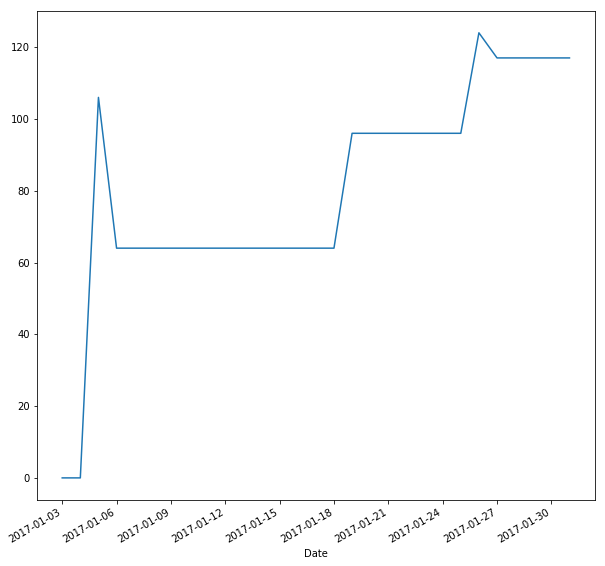

In [156]:
plt.figure(figsize=(10,10))
fcpo_eval_df[:'2017-02-01']['cummulative_returns'].plot()